***Automatic Traffic Sign Recognition Artificial Inteligence***

# Importing Dependencies

In [1]:
from sklearn.metrics import confusion_matrix, classification_report
from keras_preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.layers import *
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import random
import cv2
import os

# Loading Data

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

100% 610M/612M [00:04<00:00, 133MB/s]
100% 612M/612M [00:04<00:00, 130MB/s]


In [ ]:
! unzip gtsrb-german-traffic-sign.zip

# Data size

In [4]:
test = pd.read_csv('/content/Test.csv')
train =pd.read_csv('/content/Train.csv')
print('Test',len(test))
print('Train',len(train))

Test 12630
Train 39209


# How Data Looks

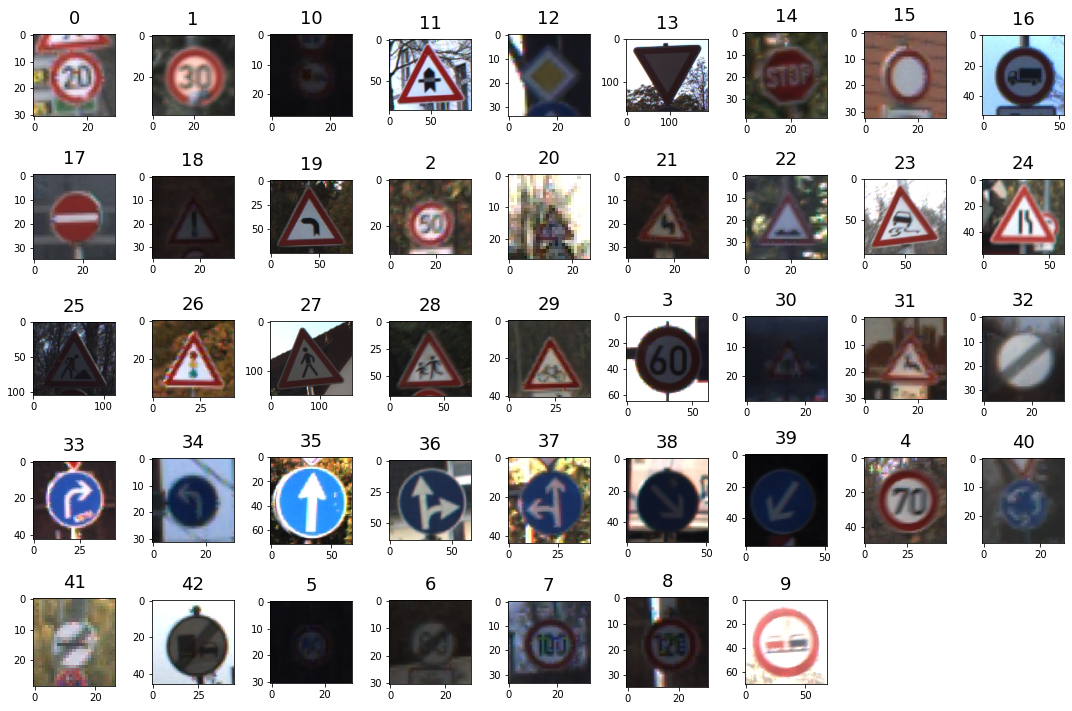

In [5]:
dataset='/content'
train_folder = os.path.join(dataset,"train")


images = []


for food_folder in sorted(os.listdir(train_folder)):
    food_items = os.listdir(train_folder + '/' + food_folder)
    food_selected = np.random.choice(food_items)
    images.append(os.path.join(train_folder,food_folder,food_selected))
                                     
fig=plt.figure(1, figsize=(15, 10))

for subplot,image_ in enumerate(images):
    category=image_.split('/')[-2]
    imgs = plt.imread(image_)
    a,b,c=imgs.shape
    fig=plt.subplot(5, 9, subplot+1)
    fig.set_title(category, pad = 10,size=18)
    plt.imshow(imgs)
    
plt.tight_layout()

# Labels

In [7]:
# mapping from class id to class name
cl = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons'}

# Data Distribution

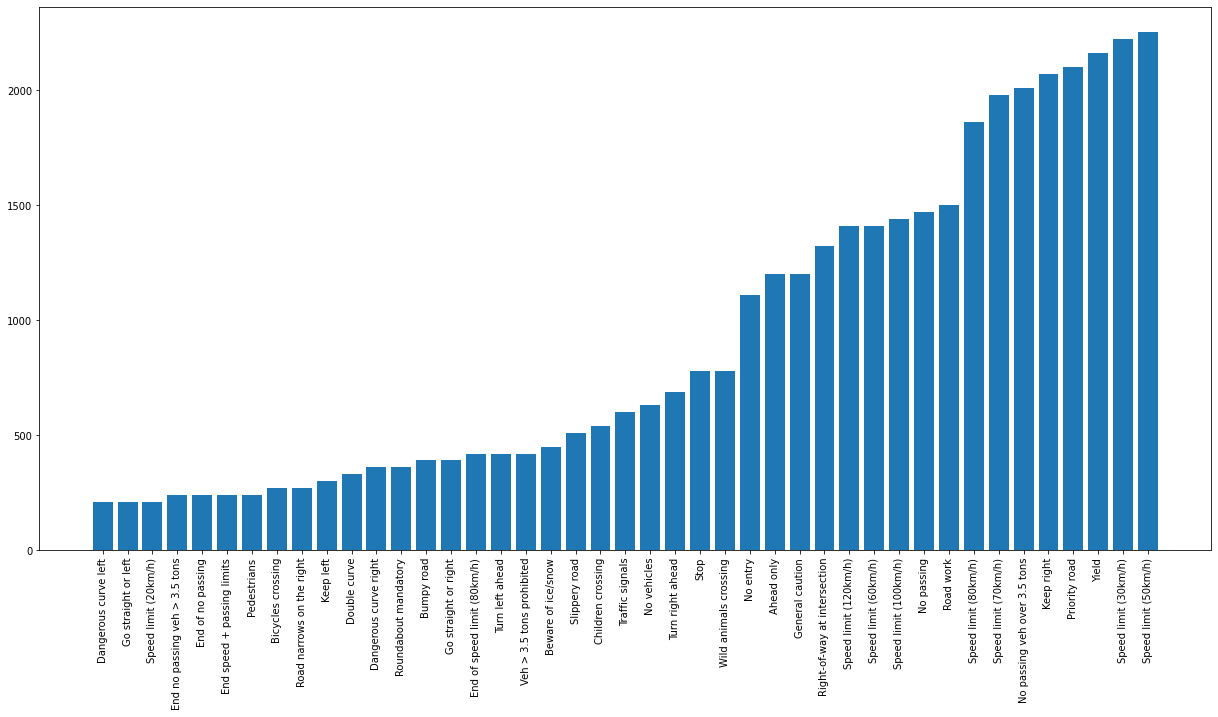

In [8]:
train_path = '/content/train'
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(cl[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

# Image Proccessing

In [9]:
train_datagen = ImageDataGenerator(horizontal_flip=False,
                                  rescale= 1./255,
                                  validation_split=0.25,
                                  rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  zoom_range=0.1)

train_path='/content/train'

train_set = train_datagen.flow_from_directory(
        train_path,
        target_size=(32,32),
        color_mode='grayscale',
        batch_size=64,
        shuffle = True,
        seed = 42,
        subset='training',
        class_mode = "categorical",
        classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 
                   '11', '12', '13', '14', '15', '16', '17', '18', '19', '20',
                   '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', 
                   '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', 
                   '41', '42'])

test_set = train_datagen.flow_from_directory(
        train_path,
        target_size=(32,32),
        color_mode='grayscale',
        seed = 42,
        shuffle = False,
        batch_size=64,
        subset='validation',
        class_mode = "categorical",
        classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 
                   '11', '12', '13', '14', '15', '16', '17', '18', '19', '20',
                   '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', 
                   '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', 
                   '41', '42'])


Found 29416 images belonging to 43 classes.
Found 9793 images belonging to 43 classes.


# After Proccessing

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(5,5))

for i in range(4):
  image = next(train_set)[0]
  image = np.squeeze(image)
  ax[i].imshow(image,cmap='gray')
  ax[i].axis('off')


# Model Building

In [22]:
from keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

# Proposed Model

In [23]:
model = tf.keras.Sequential()

model.add(Conv2D(filters=60, kernel_size=(5,5),strides=(1,1), activation="relu", input_shape=(32,32,1)))
model.add(Conv2D(filters=60, kernel_size=(5,5),strides=(1,1), activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=30, kernel_size=(5,5),strides=(1,1) ,activation="relu"))
model.add(Conv2D(filters=30, kernel_size=(5,5),strides=(1,1) ,activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))
model.add(Flatten()) 
model.add(Dense(512, activation="relu"))
model.add(Dropout(rate=0.3))
model.add(Dense(43, activation="softmax"))

model.summary()

model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 28, 28, 60)        1560      
                                                                 
 conv2d_11 (Conv2D)          (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 12, 12, 60)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 8, 8, 30)          45030     
                                                                 
 conv2d_13 (Conv2D)          (None, 4, 4, 30)          22530     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 2, 2, 30)         0         
 2D)                                                  

In [24]:
prop_history = model.fit(train_set,epochs=20,validation_data=test_set)

Epoch 1/20
460/460 [==============================] - 28s 59ms/step - loss: 2.3248 - accuracy: 0.3396 - val_loss: 0.9342 - val_accuracy: 0.7096
Epoch 2/20
460/460 [==============================] - 27s 58ms/step - loss: 0.7788 - accuracy: 0.7501 - val_loss: 0.5760 - val_accuracy: 0.8308
Epoch 3/20
460/460 [==============================] - 27s 58ms/step - loss: 0.4608 - accuracy: 0.8540 - val_loss: 0.3770 - val_accuracy: 0.8964
Epoch 4/20
460/460 [==============================] - 28s 61ms/step - loss: 0.3354 - accuracy: 0.8951 - val_loss: 0.3440 - val_accuracy: 0.9121
Epoch 5/20
460/460 [==============================] - 27s 58ms/step - loss: 0.2742 - accuracy: 0.9154 - val_loss: 0.2666 - val_accuracy: 0.9249
Epoch 6/20
460/460 [==============================] - 27s 59ms/step - loss: 0.2195 - accuracy: 0.9328 - val_loss: 0.2867 - val_accuracy: 0.9270
Epoch 7/20
460/460 [==============================] - 27s 59ms/step - loss: 0.1953 - accuracy: 0.9414 - val_loss: 0.2662 - val_accuracy:

***Plot***

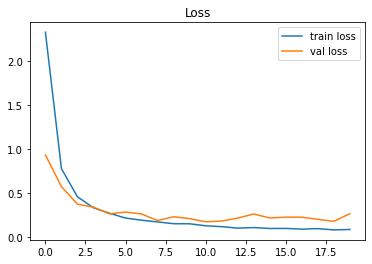

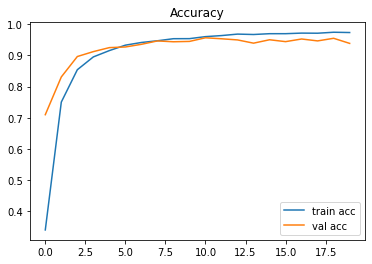

In [25]:
plt.plot(prop_history.history['loss'], label='train loss')
plt.plot(prop_history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()
plt.show()
#plt.savefig('LossVal_loss')

plt.plot(prop_history.history['accuracy'], label='train acc')
plt.plot(prop_history.history['val_accuracy'], label='val acc')
plt.title('Accuracy')
plt.legend()
plt.show()
#plt.savefig('AccVal_acc')

# Evaluation

In [26]:
cnn_auc = model.evaluate(test_set)

154/154 [==============================] - 8s 51ms/step - loss: 0.2536 - accuracy: 0.9419


In [ ]:
test_pred = model.predict(test_set)
test_pred = np.argmax(test_pred,axis = 1)
test_labels = test_set.labels

# Confusion Matrix

Text(0.5, 1.0, 'Confusion Matrix - Test Set')

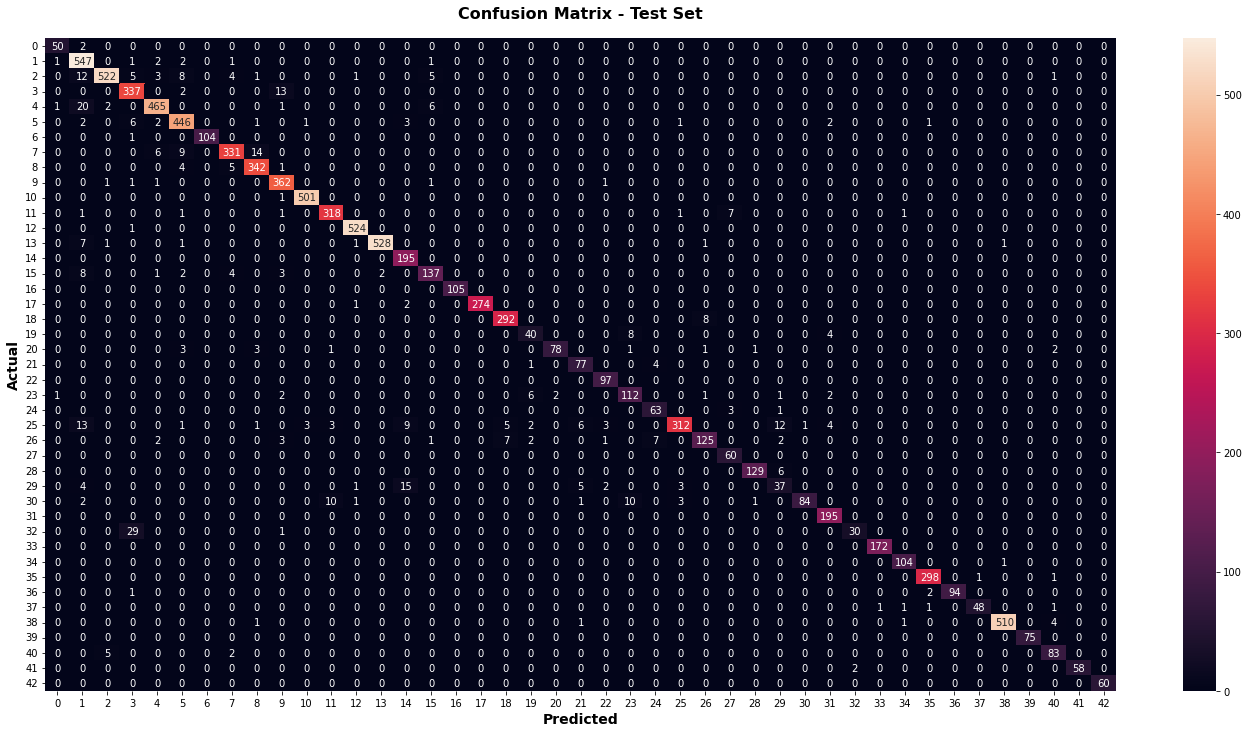

In [ ]:
plt.figure(figsize=(24, 12))
ax = sns.heatmap(tf.math.confusion_matrix(
    test_labels,
    test_pred,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None,
),
annot = True,
  fmt="d")
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20)

# Report

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(test_labels,test_pred))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95        52
           1       0.89      0.99      0.93       555
           2       0.98      0.93      0.96       562
           3       0.88      0.96      0.92       352
           4       0.96      0.94      0.95       495
           5       0.93      0.96      0.94       465
           6       1.00      0.99      1.00       105
           7       0.95      0.92      0.94       360
           8       0.94      0.97      0.96       352
           9       0.93      0.99      0.96       367
          10       0.99      1.00      1.00       502
          11       0.96      0.96      0.96       330
          12       0.99      1.00      0.99       525
          13       1.00      0.98      0.99       540
          14       0.87      1.00      0.93       195
          15       0.91      0.87      0.89       157
          16       1.00      1.00      1.00       105
          17       1.00    